<a href="https://colab.research.google.com/github/dani2442/2026-Hybrid-Signal-Learning/blob/helon/Pedagogical_example_NODE_linear_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Pedagogical Example (Real Data)

Uses `bab_datasets` to load multisine data and fit the linear physical model.


In [1]:
#!pip install torchdiffeq git+https://github.com/helonayala/bab_datasets.git
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import bab_datasets as nod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


  Cloning https://github.com/helonayala/bab_datasets.git to /tmp/pip-req-build-cu1oftu5
  Running command git clone --filter=blob:none --quiet https://github.com/helonayala/bab_datasets.git /tmp/pip-req-build-cu1oftu5
  Resolved https://github.com/helonayala/bab_datasets.git to commit 45f368bfbfe53838d9834dc3d80474696501e61a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bab_datasets: filename=bab_datasets-0.1.0-py3-none-any.whl size=5784 sha256=ebb2b80b1776f6a92058f04f1b6741dbf30693dabfee5851e3fa1d0534f882ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-xw44w7zk/wheels/23/a0/ce/e7a4541a3bb5447c58417ab1f537ee233f610bbcfb1784d848
Successfully built bab_datasets
Using device: cpu


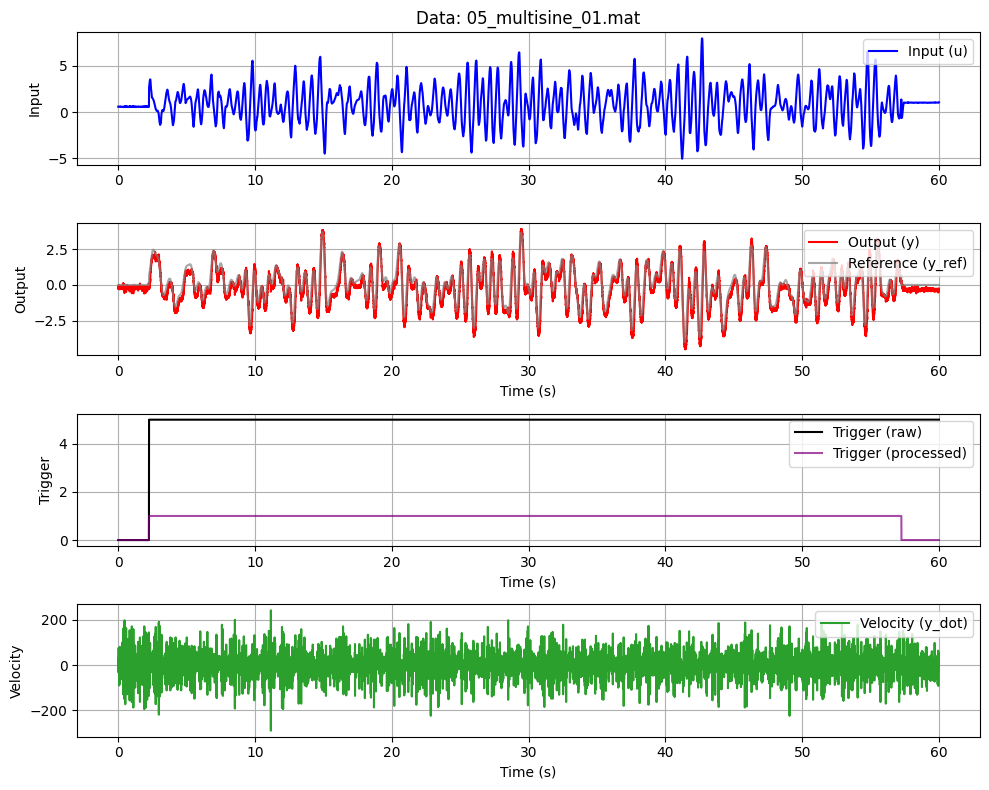

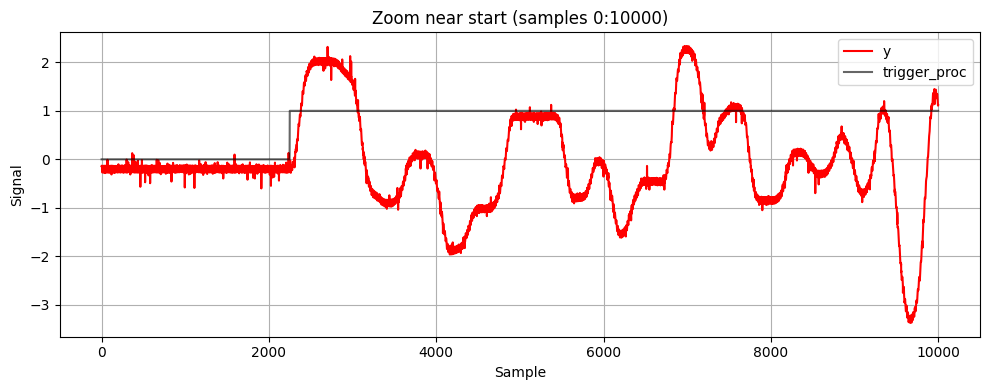

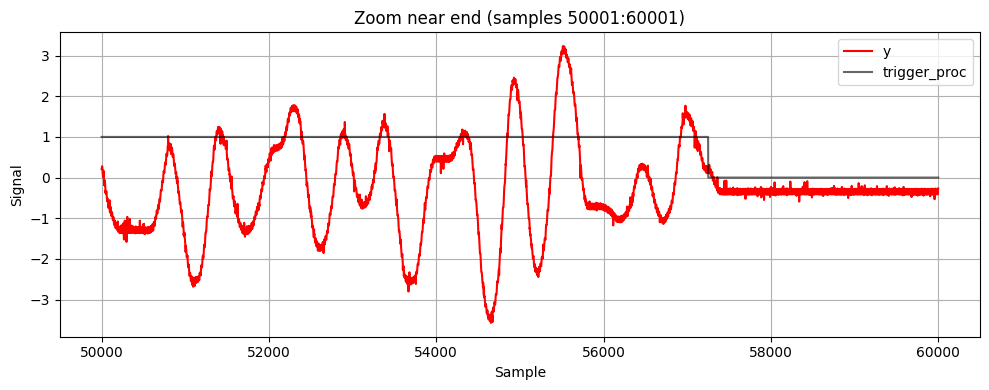

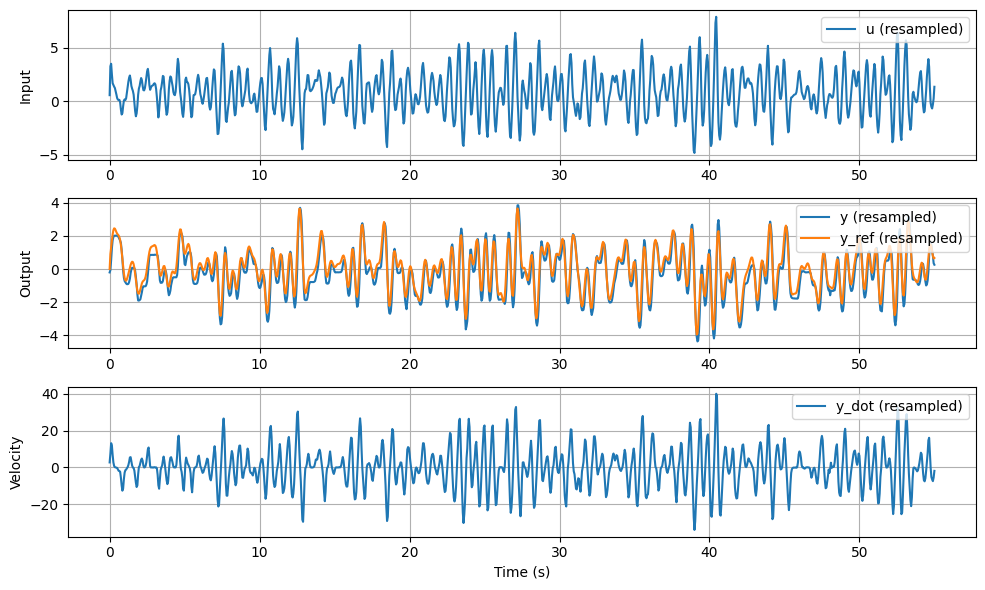

In [3]:
# ==========================================
# 1. LOAD DATA (multisine_05)
# ==========================================
data = nod.load_experiment(
    "multisine_05",
    preprocess=True,
    plot=True,
    end_idx=None,
    resample_factor=50,
    zoom_last_n=10000,
    y_dot_method="central",
)

u, y, y_ref, y_dot = data

# Time vector from sampling_time
Ts = data.sampling_time
t = np.arange(len(u)) * Ts

# Stack states: [position, velocity]
y_sim = np.column_stack([y, y_dot])


In [4]:
# ==========================================
# 2. PREPARE TENSORS
# ==========================================
t_tensor = torch.tensor(t, dtype=torch.float32).to(device)
u_tensor = torch.tensor(u, dtype=torch.float32).reshape(-1, 1).to(device)
y_tensor = torch.tensor(y_sim, dtype=torch.float32).to(device)


In [5]:
# ==========================================
# 3. MODEL DEFINITION
# ==========================================
class LinearPhysODE(nn.Module):
    # J * thdd + R * thd + K * (th + delta) = Tau * V
    # States: [th, thd]
    def __init__(self):
        super().__init__()
        self.log_J = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_R = nn.Parameter(torch.tensor(np.log(0.1), dtype=torch.float32))
        self.log_K = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(0.0, dtype=torch.float32))
        self.log_Tau = nn.Parameter(torch.tensor(np.log(1.0), dtype=torch.float32))

        self.u_series = None
        self.t_series = None
        self.batch_start_times = None

    def get_params(self):
        J = torch.exp(self.log_J)
        R = torch.exp(self.log_R)
        K = torch.exp(self.log_K)
        Tau = torch.exp(self.log_Tau)
        return J, R, K, self.delta, Tau

    def forward(self, t, x):
        J, R, K, delta, Tau = self.get_params()

        if self.batch_start_times is not None:
            t_abs = self.batch_start_times + t
        else:
            t_abs = t * torch.ones_like(x[:, 0:1])

        k_idx = torch.searchsorted(self.t_series, t_abs.reshape(-1), right=True)
        k_idx = torch.clamp(k_idx, 1, len(self.t_series) - 1)

        t1, t2 = self.t_series[k_idx - 1].unsqueeze(1), self.t_series[k_idx].unsqueeze(1)
        u1, u2 = self.u_series[k_idx - 1], self.u_series[k_idx]

        denom = (t2 - t1)
        denom[denom < 1e-6] = 1.0
        alpha = (t_abs - t1) / denom
        u_t = u1 + alpha * (u2 - u1)

        th, thd = x[:, 0:1], x[:, 1:2]
        thdd = (Tau * u_t - R * thd - K * (th + delta)) / J
        return torch.cat([thd, thdd], dim=1)


In [6]:
# ==========================================
# 4. TRAINING FUNCTION
# ==========================================

def train_model(model, name, epochs=500, lr=0.02):
    print(f"--- Training {name} ---")
    model.to(device)
    model.u_series = u_tensor
    model.t_series = t_tensor

    optimizer = optim.Adam(model.parameters(), lr=lr)

    K_STEPS = 20
    BATCH_SIZE = 128
    dt_local = (t_tensor[1] - t_tensor[0]).item()
    t_eval = torch.arange(0, K_STEPS * dt_local, dt_local, device=device)

    for epoch in range(epochs + 1):
        optimizer.zero_grad()

        start_idx = np.random.randint(0, len(t_tensor) - K_STEPS, size=BATCH_SIZE)
        x0 = y_tensor[start_idx]
        model.batch_start_times = t_tensor[start_idx].reshape(-1, 1)

        pred_state = odeint(model, x0, t_eval, method='rk4')

        batch_targets = []
        for i in start_idx:
            batch_targets.append(y_tensor[i:i + K_STEPS])
        y_target = torch.stack(batch_targets, dim=1)

        loss = torch.mean((pred_state - y_target) ** 2)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.6f}")

    return model


In [7]:
# ==========================================
# 5. TRAIN PHYSICAL MODEL
# ==========================================
phys_model = LinearPhysODE()
phys_model = train_model(phys_model, "Linear Physical Model", epochs=500, lr=0.02)

J, R, K, delta, Tau = phys_model.get_params()
print(f"identified: J={J.item():.4f}, R={R.item():.4f}, K={K.item():.4f}, delta={delta.item():.4f}, Tau={Tau.item():.4f}")


--- Training Linear Physical Model ---
Epoch 0 | Loss: 67.873550
Epoch 100 | Loss: 3.245289
Epoch 200 | Loss: 1.979969
Epoch 300 | Loss: 1.735796
Epoch 400 | Loss: 1.552449
Epoch 500 | Loss: 1.308479
identified: J=0.0275, R=0.5790, K=0.8620, delta=3.4083, Tau=3.3098


--- Running Full Data Simulation ---


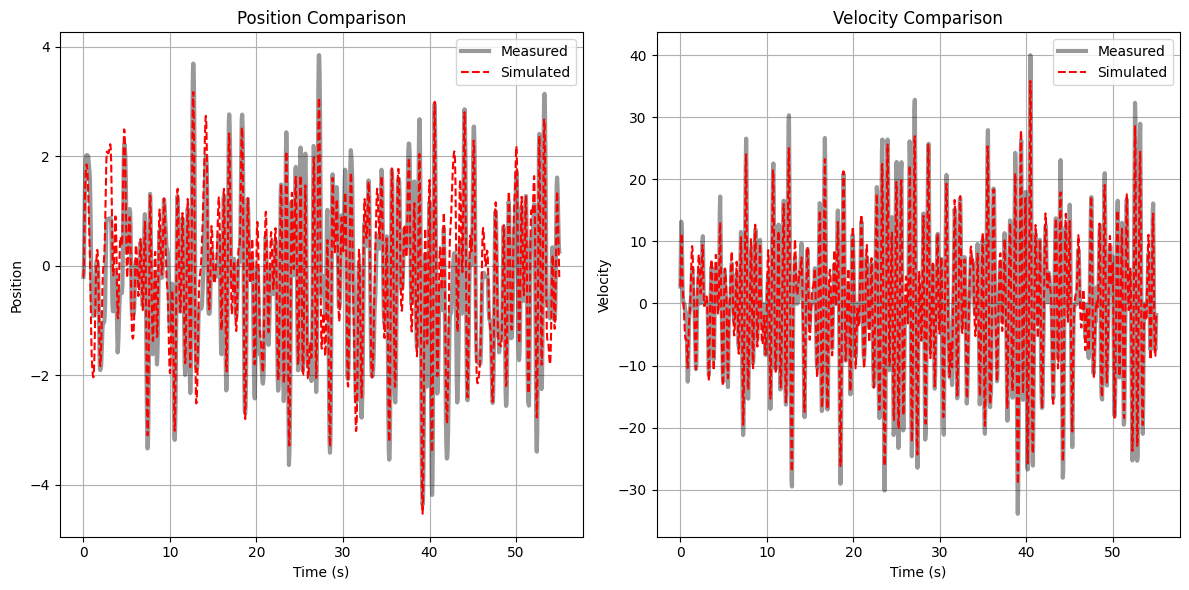

In [8]:
# ==========================================
# 6. FULL SIMULATION & COMPARISON
# ==========================================
print("--- Running Full Data Simulation ---")

with torch.no_grad():
    phys_model.batch_start_times = torch.zeros(1, 1).to(device)
    x0 = y_tensor[0].unsqueeze(0)

    full_pred = odeint(phys_model, x0, t_tensor, method='rk4')
    full_pred = full_pred.squeeze(1).cpu().numpy()

# Metrics
res_pos = y_sim[:, 0] - full_pred[:, 0]
res_vel = y_sim[:, 1] - full_pred[:, 1]

rmse_pos = np.sqrt(np.mean(res_pos**2))
rmse_vel = np.sqrt(np.mean(res_vel**2))

ss_res_pos = np.sum(res_pos**2)
ss_tot_pos = np.sum((y_sim[:, 0] - np.mean(y_sim[:, 0]))**2)
ss_res_vel = np.sum(res_vel**2)
ss_tot_vel = np.sum((y_sim[:, 1] - np.mean(y_sim[:, 1]))**2)

r2_pos = 1 - ss_res_pos / ss_tot_pos if ss_tot_pos > 0 else np.nan
r2_vel = 1 - ss_res_vel / ss_tot_vel if ss_tot_vel > 0 else np.nan

fit_pos = 100 * (1 - np.linalg.norm(res_pos) / np.linalg.norm(y_sim[:, 0] - np.mean(y_sim[:, 0])))
fit_vel = 100 * (1 - np.linalg.norm(res_vel) / np.linalg.norm(y_sim[:, 1] - np.mean(y_sim[:, 1])))

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_sim[:, 0], 'k-', alpha=0.6, linewidth=2, label='Measured')
plt.plot(t, full_pred[:, 0], 'r--', linewidth=1.5, label='Simulated')
plt.plot(t, res_pos, color='lightgray', linewidth=1.0, label='Residual')
plt.title(f"Position Comparison (R2={r2_pos:.4f})")
plt.ylabel("Position")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, y_sim[:, 1], 'k-', alpha=0.6, linewidth=2, label='Measured')
plt.plot(t, full_pred[:, 1], 'r--', linewidth=1.5, label='Simulated')
plt.plot(t, res_vel, color='lightgray', linewidth=1.0, label='Residual')
plt.title(f"Velocity Comparison (R2={r2_vel:.4f})")
plt.xlabel("Time (s)")
plt.ylabel("Velocity")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"RMSE pos: {rmse_pos:.6f} | R2 pos: {r2_pos:.6f} | FIT% pos: {fit_pos:.2f}")
print(f"RMSE vel: {rmse_vel:.6f} | R2 vel: {r2_vel:.6f} | FIT% vel: {fit_vel:.2f}")


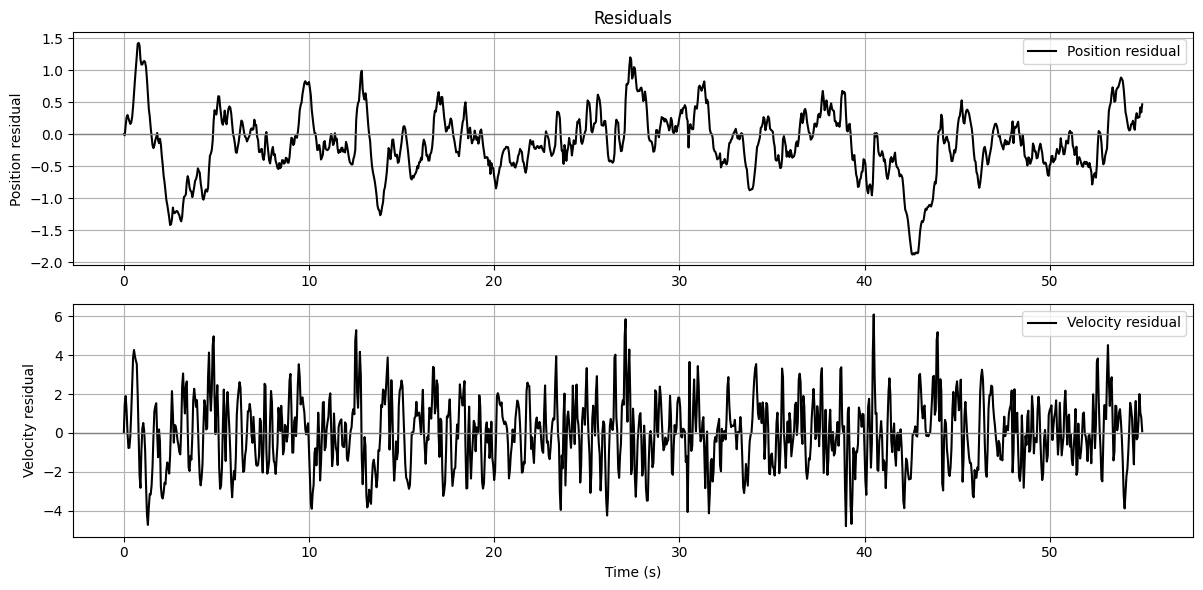

In [9]:
# ==========================================
# 7. RESIDUALS (Measured - Simulated)
# ==========================================
res_pos = y_sim[:, 0] - full_pred[:, 0]
res_vel = y_sim[:, 1] - full_pred[:, 1]

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, res_pos, 'k-', linewidth=1.5, label='Position residual')
plt.axhline(0, color='gray', linewidth=1)
plt.title("Residuals")
plt.ylabel("Position residual")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, res_vel, 'k-', linewidth=1.5, label='Velocity residual')
plt.axhline(0, color='gray', linewidth=1)
plt.ylabel("Velocity residual")
plt.xlabel("Time (s)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# ==========================================
# 7. DIAGNOSTICS (position only)
# ==========================================

# Residual ACF (position)
res = res_pos - np.mean(res_pos)
N = len(res)
max_lag = min(2000, N - 1)
acf = np.correlate(res, res, mode='full')
acf = acf[N-1:N+max_lag] / acf[N-1]

conf = 1.96 / np.sqrt(N)

plt.figure(figsize=(10, 4))
plt.stem(np.arange(0, max_lag+1), acf, linefmt='k-', markerfmt='ko', basefmt=' ')
plt.axhline(conf, color='red', linestyle='--', linewidth=1)
plt.axhline(-conf, color='red', linestyle='--', linewidth=1)
plt.title('Residual ACF (Position)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

# Spectrum: measured vs simulated vs residual (position)
fs = 1.0 / Ts
n = len(res_pos)

freqs = np.fft.rfftfreq(n, d=Ts)
Y_meas = np.fft.rfft(y_sim[:, 0])
Y_pred = np.fft.rfft(full_pred[:, 0])
Y_res = np.fft.rfft(res_pos)

plt.figure(figsize=(10, 4))
plt.semilogy(freqs, np.abs(Y_meas), label='Measured')
plt.semilogy(freqs, np.abs(Y_pred), label='Simulated')
plt.semilogy(freqs, np.abs(Y_res), label='Residual')
plt.title('Spectrum (Position)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Time window zooms (position only)
win_sec = 5.0
win_n = int(win_sec / Ts)

starts = [0, max(0, (len(t) - win_n) // 2), max(0, len(t) - win_n)]
labels = ["Start", "Middle", "End"]

plt.figure(figsize=(10, 8))
for i, s in enumerate(starts):
    e = min(len(t), s + win_n)
    plt.subplot(3, 1, i+1)
    plt.plot(t[s:e], y_sim[s:e, 0], 'k-', label='Measured')
    plt.plot(t[s:e], full_pred[s:e, 0], 'r--', label='Simulated')
    plt.title(f"Zoom ({labels[i]})")
    plt.ylabel('Position')
    if i == 2:
        plt.xlabel('Time (s)')
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()
